# Estimating Monthly USA GDP figures via Expenditure Approach and the Holt-Winters Model

# Part 1: Introduction to the Theory, Codebook and Python Libraries

Gross Domestic Product (GDP) is often thought of and calculated with an [Expenditure Approach](https://courses.lumenlearning.com/boundless-economics/chapter/measuring-output-using-gdp/) such that $$GDP=C+I+G+(X−M)$$ where  C  = Consumption,  I  = Investment,  G  = Government Spending, &  (X–M)  = Net Exports.

The United States of America( USA)'s GDP (US GDP) is released quarterly by the [Bureau of Economic Analysis, U.S. Department of Commerce](http://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=USGDP...B&prev=99_GDP). The only aforementioned component of US GDP released on a monthly basis is C, [USA's Consumption Data](http://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=USPERCONB&prev=99_PERSONAL+CONSUMPTION+EXPENDITURES+(AR)&prev_csrc=12). Monthly figures of GDP figures are thus not available, and estimating such values have proven of interest in academia (Mitchell, Smith, Weale, Wright, and Salazar (2005)) and in practice.

In this article, we will attempt to compute monthly US GDP estimates via the Holt-Winters (HW) method (resources on the HW model can be found [here](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1) and - for academics - [here](https://otexts.com/fpp2/holt-winters.html)). We then put ourselves in the shoes of an analyst who only has quarterly GDP component data (C, I, G or (X-M)). She/He uses the latest quarterly releases of GDP component datawhich spans from 2007 (in this study) to last quarter (last month at the earliest). She/He then uses the [Holt-Winters method](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1) model to compute a forecast for the current period (month).

Accurate monthly GDP figures can be of great use in macroeconomic models going forward.

## Development Tools & Resources
The example code demonstrating the use case is based on the following development tools and resources:

- Refinitiv's [DataStream](https://www.refinitiv.com/en/products/datastream-macroeconomic-analysis) Web Services (DSWS): Access to DataStream data. A DataStream or Refinitiv Workspace IDentification (ID) will be needed to run the code bellow.
- Python Environment:
Tested with Python 3.7
- Packages: [DatastreamDSWS](https://www.refinitiv.com/en/products/datastream-macroeconomic-analysis), [Numpy](https://numpy.org/), [Pandas](https://pandas.pydata.org/), [statsmodel](https://www.statsmodels.org/stable/index.html), [scipy](https://www.scipy.org/) and [Matplotlib](https://matplotlib.org/). The Python built in modules [os](https://docs.python.org/3/library/os.html), [warnings](https://docs.python.org/3/library/warnings.html?highlight=warnings#module-warnings), [statistics](https://docs.python.org/3/library/statistics.html), [datetime](https://docs.python.org/3/library/datetime.html) and [dateutil](https://dateutil.readthedocs.io/en/stable/) are also required.

$ \\ $
## Import libraries

In [1]:
# The ' from ... import ' structure here allows us to only import the
# module ' python_version ' from the library ' platform ':
import platform
from platform import python_version
print("This code runs on Python version " + python_version() + " in " + platform.architecture()[0])

This code runs on Python version 3.8.2 in 32bit


In [2]:
import DatastreamDSWS as DSWS

# We can use our Refinitiv's Datastream Web Socket (DSWS) API keys that allows us to be identified by Refinitiv's back-end services and enables us to request (and fetch) data:

# The username and password is placed in a text file so that it may be used in this code without showing it itself.
DSWS_username = open("Datastream_username.txt","r")
DSWS_password = open("Datastream_password.txt","r")

ds = DSWS.Datastream(username = str(DSWS_username.read()), password = str(DSWS_password.read()))

# It is best to close the files we opened in order to make sure that we don't stop any other services/programs from accessing them if they need to.
DSWS_username.close()
DSWS_password.close()

In [3]:
import datetime # datetime will allow us to manipulate Western World dates
import dateutil # dateutil will allow us to manipulate dates in equations
import warnings # warnings will allow us to manipulate warning messages (such as depreciation messages)

In [4]:
import statistics # This is a Python-built-in module/library, therefore it does not have a specific version number.
import numpy
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import scipy
from scipy import stats
for i,j in zip(["numpy", "statsmodels", "scipy"], [numpy, statsmodels, scipy]):
    print("The " + str(i) + " library imported in this code is version: " + j.__version__)

The numpy library imported in this code is version: 1.21.2
The statsmodels library imported in this code is version: 0.12.2
The scipy library imported in this code is version: 1.6.2


In [5]:
import pandas
pandas.set_option('display.max_columns', None) # This line will ensure that all columns of our data-frames are always shown
print("The pandas library imported in this code is version: " + pandas.__version__)

The pandas library imported in this code is version: 1.3.5


In [6]:
import matplotlib
import matplotlib.pyplot as plt
print("The matplotlib library imported in this code is version: "+ matplotlib.__version__)

The matplotlib library imported in this code is version: 3.2.1


The cell below defines a function that appends our monthly data-frame with chosen data

$$ \\ $$
# Part 2: Introduction to Some Python Fundamentals and First Functions

In [7]:
# Object:
test = "Tea"
# Type of an object:
type(test)

str

In [8]:
# Functions:
print(test)

Tea


In [9]:
print("Tea")

Tea


In [10]:
# Strings 1:
"9" + "1"

'91'

In [11]:
# # Strings 2:
# "9" - "1"

In [12]:
# Numbers:
9 - 1

8

In [13]:
type(float(1))

float

In [14]:
type(1)

int

In [15]:
def Add_One(Number):
    print(Number + 1)

In [16]:
Add_One(Number = 8)

9


## Get Coding
### Monthly Data
#### [U.S.A.'s Consumption Data](http://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=USPERCONB&prev=99_PERSONAL+CONSUMPTION+EXPENDITURES+(AR)&prev_csrc=12)

In [17]:
data = ds.get_data(tickers = 'USPERCONB', # this is the ticker for United States, Personal Outlays, Personal Consumption Expenditure, Overall, Total, Current Prices, AR, SA, USD
                   fields = "X", # DataStream's default field is 'X'
                   start = '1950-02-01',
                   freq = 'M') * 1000000000

In [18]:
data

Instrument,USPERCONB
Field,X
Dates,
1950-02-15,NaN
1950-03-15,NaN
1950-04-15,NaN
1950-05-15,NaN
1950-06-15,NaN
...,...
2022-03-15,1.683117e+13
2022-04-15,1.692392e+13


In [19]:
data.dropna()

Instrument,USPERCONB
Field,X
Dates,
1959-01-15,3.060910e+11
1959-02-15,3.095540e+11
1959-03-15,3.127020e+11
1959-04-15,3.121930e+11
1959-05-15,3.161300e+11
...,...
2022-01-15,1.654334e+13
2022-02-15,1.663577e+13


In [20]:
data.iloc[200]

Instrument  Field
USPERCONB   X        4.882850e+11
Name: 1966-10-15, dtype: float64

In [21]:
data.index

Index(['1950-02-15', '1950-03-15', '1950-04-15', '1950-05-15', '1950-06-15',
       '1950-07-15', '1950-08-15', '1950-09-15', '1950-10-15', '1950-11-15',
       ...
       '2021-10-15', '2021-11-15', '2021-12-15', '2022-01-15', '2022-02-15',
       '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15', '2022-07-15'],
      dtype='object', name='Dates', length=870)

In [22]:
# The first 8 characters of the index is the ' yyyy-mm- ', onto which will be added '01'.
data.index = data.index.astype("str").str.slice_replace(8, repl = "01")

In [23]:
data

Instrument,USPERCONB
Field,X
Dates,
1950-02-01,NaN
1950-03-01,NaN
1950-04-01,NaN
1950-05-01,NaN
1950-06-01,NaN
...,...
2022-03-01,1.683117e+13
2022-04-01,1.692392e+13


#### Set this up programatically:

In [24]:
# This function will put Refinitiv's DataStream data into a Pandas Dafaframe and normalise it to the 1st of the month it was collected in.
def Translate_to_First_of_the_Month(data, dataname):
    
    # The first 8 characters of the index is the ' yyyy-mm- ', onto which will be added '01'.
    data.index = data.index.astype("str").str.slice_replace(8, repl = "01")
    
    # This line resets the index to a pandas datetime format
    data.index = pandas.to_datetime(data.index)
    
    # This line renames the column as specified in the function
    data.columns = [dataname]
    return data

In [25]:
# Add what we've got to our Data Frame:
df = pandas.DataFrame([])
df = pandas.merge(df, Translate_to_First_of_the_Month(data = data, dataname = "Consumption (monthly data)"),
                  how = "outer", left_index = True, right_index=True)

In [26]:
df

,Consumption (monthly data)
Dates,
1950-02-01,NaN
1950-03-01,NaN
1950-04-01,NaN
1950-05-01,NaN
1950-06-01,NaN
...,...
2022-03-01,1.683117e+13
2022-04-01,1.692392e+13
2022-05-01,1.695658e+13


In [27]:
df = pandas.DataFrame([])
def Add_to_df(data, dataname):
    
    # The ' global df ' allows the function to take the pre-deffined variable ' df ' for granted and work from there
    global df
    
    DS_Data_monthly = Translate_to_First_of_the_Month(data, dataname)
    
    # Note that the bellow is (purposefully) different to ' df[dataname] =  DS_Data_monthly'
    df = pandas.merge(df, DS_Data_monthly,
                      how = "outer",
                      left_index = True,
                      right_index=True)

In [28]:
Add_to_df(data = ds.get_data(tickers = 'USPERCONB', # this is the ticker for United States, Personal Outlays, Personal Consumption Expenditure, Overall, Total, Current Prices, AR, SA, USD
                             fields = "X", # DataStream's default field is 'X'
                             start = '1950-02-01',
                             freq = 'M') * 1000000000, # This data is given in units of 1000000000
          dataname = "Consumption (monthly data)")

In [29]:
df

,Consumption (monthly data)
Dates,
1950-02-01,NaN
1950-03-01,NaN
1950-04-01,NaN
1950-05-01,NaN
1950-06-01,NaN
...,...
2022-03-01,1.683117e+13
2022-04-01,1.692392e+13
2022-05-01,1.695658e+13


$$ \\ $$
# Part 3: Setup Quarterly data sets

In [30]:
data = ds.get_data(tickers = "USGFCF..B", # Investment
                   fields = "X", # DataStream's default field is 'X'
                   start = '1950-02-01', # end
                   freq = 'M') * 1000000000

In [31]:
# range:
range(0, 4)

range(0, 4)

In [32]:
for i in range(1,4):
    print(i)

1
2
3


In [33]:
# length:
len(data)

291

In [34]:
data_proper = []
data_full_index = []

In [35]:
data_proper, data_full_index = [], []

In [36]:
data_proper.append(5)
data_proper

[5]

In [37]:
# reminder 1:
number = 0
data.iloc[number]

Instrument  Field
USGFCF..B   X        4.472500e+10
Name: 1950-02-15, dtype: float64

In [38]:
type(data.iloc[number])

pandas.core.series.Series

In [39]:
# reminder 2:
float(data.iloc[number])

44725000000.0

In [40]:
for number in range(1, len(data)):
    data_proper.append(float(data.iloc[number]))
# data_proper

In [41]:
type(data_proper)

list

In [42]:
data_proper[2]

54465000000.0

In [43]:
# reset list to be empty
data_proper = []
data_proper

[]

In [44]:
data_proper = []
[data_proper.append(float(data.iloc[number])) for number in range(0, len(data))]
data_proper

[44725000000.0,
 49458000000.0,
 54465000000.0,
 54397000000.0,
 54196000000.0,
 52591000000.0,
 52241000000.0,
 52365000000.0,
 53400000000.0,
 54528000000.0,
 51646000000.0,
 55463000000.0,
 57773000000.0,
 58538000000.0,
 59104000000.0,
 58452000000.0,
 57683000000.0,
 58827000000.0,
 61062000000.0,
 62455000000.0,
 64899000000.0,
 68068000000.0,
 70452000000.0,
 71650000000.0,
 71904000000.0,
 73435000000.0,
 74698000000.0,
 74902000000.0,
 75566000000.0,
 75250000000.0,
 76530000000.0,
 75563000000.0,
 70739000000.0,
 69300000000.0,
 70452000000.0,
 74766000000.0,
 79290000000.0,
 82093000000.0,
 83222000000.0,
 82404000000.0,
 85276000000.0,
 83872000000.0,
 82057000000.0,
 81775000000.0,
 80926000000.0,
 82316000000.0,
 84261000000.0,
 86935000000.0,
 88666000000.0,
 91262000000.0,
 91972000000.0,
 91604000000.0,
 92821000000.0,
 96814000000.0,
 98896000000.0,
 102125000000.0,
 105350000000.0,
 106062000000.0,
 107939000000.0,
 109968000000.0,
 114998000000.0,
 118484000000.0,
 

In [45]:
data_proper = []
[data_proper.append(float(data.iloc[j])) for j in range(0, len(data))]
data_proper

[44725000000.0,
 49458000000.0,
 54465000000.0,
 54397000000.0,
 54196000000.0,
 52591000000.0,
 52241000000.0,
 52365000000.0,
 53400000000.0,
 54528000000.0,
 51646000000.0,
 55463000000.0,
 57773000000.0,
 58538000000.0,
 59104000000.0,
 58452000000.0,
 57683000000.0,
 58827000000.0,
 61062000000.0,
 62455000000.0,
 64899000000.0,
 68068000000.0,
 70452000000.0,
 71650000000.0,
 71904000000.0,
 73435000000.0,
 74698000000.0,
 74902000000.0,
 75566000000.0,
 75250000000.0,
 76530000000.0,
 75563000000.0,
 70739000000.0,
 69300000000.0,
 70452000000.0,
 74766000000.0,
 79290000000.0,
 82093000000.0,
 83222000000.0,
 82404000000.0,
 85276000000.0,
 83872000000.0,
 82057000000.0,
 81775000000.0,
 80926000000.0,
 82316000000.0,
 84261000000.0,
 86935000000.0,
 88666000000.0,
 91262000000.0,
 91972000000.0,
 91604000000.0,
 92821000000.0,
 96814000000.0,
 98896000000.0,
 102125000000.0,
 105350000000.0,
 106062000000.0,
 107939000000.0,
 109968000000.0,
 114998000000.0,
 118484000000.0,
 

In [46]:
data_proper = []
[data_proper.append(float(data.iloc[j])) for j in [1,1,1]]
data_proper

[49458000000.0, 49458000000.0, 49458000000.0]

In [47]:
# Manipulating Dates 1:
str(data.index[1])

'1950-05-15'

In [48]:
# Manipulating Dates 2:
str(data.index[1])[0:8] + "01"

'1950-05-01'

In [49]:
# Manipulating Dates 3:
datetime.datetime.strptime(str(data.index[1]), "%Y-%m-%d")

datetime.datetime(1950, 5, 15, 0, 0)

In [50]:
# Manipulating Dates 4:
datetime.datetime.strptime(str(data.index[1])[0:8] + "01", "%Y-%m-%d")

datetime.datetime(1950, 5, 1, 0, 0)

In [51]:
# Manipulating Dates 5:
datetime.datetime.strptime(str(data.index[1])[0:8] + "01", "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months =+ 1)

datetime.datetime(1950, 6, 1, 0, 0)

In [52]:
data_full_index = [] # Create empty list

for j in range(0,3):
    data_full_index.append(datetime.datetime.strptime(str(data.index[1])[0:8] + "01", "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months =+ j))

data_full_index

[datetime.datetime(1950, 5, 1, 0, 0),
 datetime.datetime(1950, 6, 1, 0, 0),
 datetime.datetime(1950, 7, 1, 0, 0)]

In [53]:
data_full_index = [] # Create empty list
[data_full_index.append(datetime.datetime.strptime(str(data.index[1])[0:8] + "01", "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months =+ j)) for j in range(0,3)]
data_full_index

[datetime.datetime(1950, 5, 1, 0, 0),
 datetime.datetime(1950, 6, 1, 0, 0),
 datetime.datetime(1950, 7, 1, 0, 0)]

In [54]:
data = ds.get_data(tickers = "USGFCF..B", fields = "X", start = '1950-02-01', freq = 'M') * 1000000000 # reset ' data '

In [55]:
data_proper, data_full_index = [], []
for i in range(0, len(data)):
    [data_proper.append(float(data.iloc[j])) for j in [i,i,i]]
    [data_full_index.append(datetime.datetime.strptime(str(data.index[i])[0:8] + "01", "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months =+ j)) for j in range(0,3)]

data = pandas.DataFrame(data = data_proper, columns = ["Investment"], index = data_full_index)

data.index = pandas.to_datetime(data.index)
data

,Investment
1950-02-01,4.472500e+10
1950-03-01,4.472500e+10
1950-04-01,4.472500e+10
1950-05-01,4.945800e+10
1950-06-01,4.945800e+10
...,...
2022-06-01,NaN
2022-07-01,NaN
2022-08-01,NaN
2022-09-01,NaN


In [56]:
# Our data is released quarterly, so we have to shape it into a monthly database. The function below will allow for this:
def Quarterly_To_Monthly(data, dataname, deflator = False):
    
    data_proper, data_full_index = [], []
    
    if deflator == True:
        for i in range(0, len(data.dropna())):
            [data_proper.append(float(data.dropna().iloc[j])) for j in [i,i,i]]
            [data_full_index.append(datetime.datetime.strptime(str(data.dropna().index[i])[0:8] + "01", "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months =+ j)) for j in range(0,3)]
        data = pandas.DataFrame(data = [1 / (i / data_proper[-1]) for i in data_proper], columns = ["Investment"], index = data_full_index)
    
    else:
        for i in range(0, len(data)):
            [data_proper.append(float(data.iloc[j])) for j in [i,i,i]]
            [data_full_index.append(datetime.datetime.strptime(str(data.index[i])[0:8] + "01", "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months =+ j)) for j in range(0,3)]
        data = pandas.DataFrame(data = data_proper, columns = [dataname], index = data_full_index)
    
    data.index = pandas.to_datetime(data.index)
    
    return data

In [57]:
help(Quarterly_To_Monthly)

Help on function Quarterly_To_Monthly in module __main__:

Quarterly_To_Monthly(data, dataname, deflator=False)
    # Our data is released quarterly, so we have to shape it into a monthly database. The function below will allow for this:



In [58]:
# Our data is released quarterly, so we have to shape it into a monthly database. The function below will allow for this:
def Quarterly_To_Monthly(data, dataname, deflator = False):
    """Quarterly data can sometimes be recorded in a monthly data-frames.
    This function returns a pandas data-frame in which inter-quarterly cells are populatd.
    
    data (pandas.DataFrame): a pandas data-frame of the quarterly data
    that is wanted in a monthly pandas data-frame
    
    dataname (str): a string of the name wanted for the column of returned data-frame
    
    deflator (bool): Set to False by default. If the data passed is an inflator,
    setting ' deflator ' to True will inverse it)
    """
    
    data_proper, data_full_index = [], []
    
    if deflator == True:
        for i in range(0, len(data.dropna())):
            [data_proper.append(float(data.dropna().iloc[j])) for j in [i,i,i]]
            [data_full_index.append(datetime.datetime.strptime(str(data.dropna().index[i])[0:8] + "01", "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months =+ j)) for j in range(0,3)]
        data = pandas.DataFrame(data = [1 / (i / data_proper[-1]) for i in data_proper], columns = ["Investment"], index = data_full_index)
    
    else:
        for i in range(0, len(data)):
            [data_proper.append(float(data.iloc[j])) for j in [i,i,i]]
            [data_full_index.append(datetime.datetime.strptime(str(data.index[i])[0:8] + "01", "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months =+ j)) for j in range(0,3)]
        data = pandas.DataFrame(data = data_proper, columns = [dataname], index = data_full_index)
    
    data.index = pandas.to_datetime(data.index)
    
    return data

In [59]:
help(Quarterly_To_Monthly)

Help on function Quarterly_To_Monthly in module __main__:

Quarterly_To_Monthly(data, dataname, deflator=False)
    Quarterly data can sometimes be recorded in a monthly data-frames.
    This function returns a pandas data-frame in which inter-quarterly cells are populatd.
    
    data (pandas.DataFrame): a pandas data-frame of the quarterly data
    that is wanted in a monthly pandas data-frame
    
    dataname (str): a string of the name wanted for the column of returned data-frame
    
    deflator (bool): Set to False by default. If the data passed is an inflator,
    setting ' deflator ' to True will inverse it)



In [60]:
multiplier = 1000000000
ticker = "USGFCF..B"
data_name = "Investment"
field = "X"
dsdata = ds.get_data(tickers = ticker, fields = field, start = '1950-02-01', freq = 'M') * multiplier
dsdata

Instrument,USGFCF..B
Field,X
Dates,
1950-02-15,4.472500e+10
1950-05-15,4.945800e+10
1950-08-15,5.446500e+10
1950-11-15,5.439700e+10
1951-02-15,5.419600e+10
...,...
2021-08-15,4.159769e+12
2021-11-15,4.277839e+12


In [61]:
# Adding data for every quarter in our df:
Add_to_df(data = dsdata.copy(), dataname = data_name + " (quarterly data)")

In [62]:
Quarterly_To_Monthly(dsdata.copy(), dataname = data_name + " (quarterly data)", deflator = False)

,Investment (quarterly data)
1950-02-01,4.472500e+10
1950-03-01,4.472500e+10
1950-04-01,4.472500e+10
1950-05-01,4.945800e+10
1950-06-01,4.945800e+10
...,...
2022-06-01,NaN
2022-07-01,NaN
2022-08-01,NaN
2022-09-01,NaN


In [63]:
# Adding quarterly data for every month in our df:
Add_to_df(data = Quarterly_To_Monthly(dsdata.copy(), dataname = data_name + " (quarterly data)", deflator = False),
          dataname = data_name + " (monthly step data)")

In [64]:
def Collect_Quarterly_Data(ticker, data_name, field = "X", start = "1950-02-01", freq = "M",
                           multiplier = 1):
    """ This function was created specifically for this script/article. It decreases the
    number of repeated code lines collecting data in several forms in our df.
    
    ticker (str/list): string of the one DataStream ticker or list of multiple DataStream
    tickers to be collected.
    
    field (str): Set to "X" by default. Field to be collected fo rthe ticker(s) in question.
    
    start (str): Set to "1950-02-01" by default. This is the date at which the data is to be
    collected from on DataStream.
    
    freq (str): Set to "M" by default. This is the frequency at which you would like the
    data to be collected from DataStream. "M" for monthly, "Q" for quarterly, "A" for 
    annually, et cetera. If ' freq ' is set to a higher frequency than is available on
    DataSream, the highest possible one will be used (exempli gratia: if asking for "M"
    when only "Q" data is available, data will be collected as if freq = "Q").
    
    multiplier (int/float): Set to ' 1 ' by default. Our collected data will be multiplied
    by this multiplier.
    """
    
    # Only DataStream requests returning numbers are meant to be ask for in this function.
    # The following try loop will account for the case where DataStream returns something
    # else (or somenthing else is asked of it):
    try:
        # The multiplier can only be used if data in ' dsdata ' is numeric
        dsdata = ds.get_data(tickers = ticker, fields = field,
                             start = '1950-02-01', freq = 'M') * multiplier
    except:
        dsdata = ds.get_data(tickers = ticker, fields = field,
                             start = '1950-02-01', freq = 'M')
    
    # Adding data for every quarter in our df:
    Add_to_df(data = dsdata.copy(), dataname = data_name + " (quarterly data)")
    
    # Adding quarterly data for every month in our df:
    Add_to_df(data = Quarterly_To_Monthly(dsdata.copy(),
                                          dataname = data_name + " (quarterly data)",
                                          deflator = False),
              dataname = data_name + " (monthly step data)")

### [U.S.A.'s Government Investment](http://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=USCNGOV.B&prev=99_government+consumption+expenditures+and+gross+investment&nav_category=12)

In [65]:
Collect_Quarterly_Data(ticker = "USCNGOV.B", data_name = "Government Investment", multiplier = 1000000000)

### [U.S.A.'s Net Exports of Goods and Services](http://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=USBALGSVB&prev=99_Net+Exports+of+Goods+and+Services&nav_category=12)

In [66]:
Collect_Quarterly_Data(ticker = "USBALGSVB", data_name = "Net Exports", multiplier = 1000000000)

$$ \\ $$
# Part 4: Second Functions and Graphs

$$ \\ $$
### G.D.P. Component Sum

In [67]:
# Adding Columns to Pandas Dataframes:
test = pandas.DataFrame([])
test

""


In [68]:
for i in range(ord('a'), ord('g')):
    print(chr(i))

a
b
c
d
e
f


In [69]:
test["Test Column"] = [chr(i) for i in range(ord('a'), ord('g'))]
test

,Test Column
0,a
1,b
2,c
3,d
4,e
5,f


In [70]:
df

,Consumption (monthly data),Investment (quarterly data),Investment (monthly step data),Government Investment (quarterly data),Government Investment (monthly step data),Net Exports (quarterly data),Net Exports (monthly step data)
1950-02-01,NaN,4.472500e+10,4.472500e+10,4.895600e+10,4.895600e+10,2.203000e+09,2.203000e+09
1950-03-01,NaN,NaN,4.472500e+10,NaN,4.895600e+10,NaN,2.203000e+09
1950-04-01,NaN,NaN,4.472500e+10,NaN,4.895600e+10,NaN,2.203000e+09
1950-05-01,NaN,4.945800e+10,4.945800e+10,4.964300e+10,4.964300e+10,1.643000e+09,1.643000e+09
1950-06-01,NaN,NaN,4.945800e+10,NaN,4.964300e+10,NaN,1.643000e+09
...,...,...,...,...,...,...,...
2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
df["GDP Component Sum (quarterly data)"] = df.dropna()["Consumption (monthly data)"] + df.dropna()["Investment (quarterly data)"] + df.dropna()["Government Investment (quarterly data)"] + df.dropna()["Net Exports (quarterly data)"]

In [72]:
df

,Consumption (monthly data),Investment (quarterly data),Investment (monthly step data),Government Investment (quarterly data),Government Investment (monthly step data),Net Exports (quarterly data),Net Exports (monthly step data),GDP Component Sum (quarterly data)
1950-02-01,NaN,4.472500e+10,4.472500e+10,4.895600e+10,4.895600e+10,2.203000e+09,2.203000e+09,NaN
1950-03-01,NaN,NaN,4.472500e+10,NaN,4.895600e+10,NaN,2.203000e+09,NaN
1950-04-01,NaN,NaN,4.472500e+10,NaN,4.895600e+10,NaN,2.203000e+09,NaN
1950-05-01,NaN,4.945800e+10,4.945800e+10,4.964300e+10,4.964300e+10,1.643000e+09,1.643000e+09,NaN
1950-06-01,NaN,NaN,4.945800e+10,NaN,4.964300e+10,NaN,1.643000e+09,NaN
...,...,...,...,...,...,...,...,...
2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
df["GDP Component Sum (monthly step data)"] = df["Consumption (monthly data)"] + df["Investment (monthly step data)"] + df["Government Investment (monthly step data)"] + df["Net Exports (monthly step data)"]

#### Plotting

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\594017210.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed


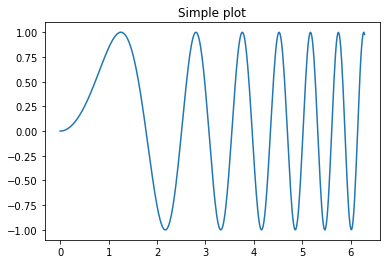

In [74]:
# First create some toy data:
x = numpy.linspace(0, 2*numpy.pi, 400)
y = numpy.sin(x**2)

# Create just a figure and only one subplot
# Remember we did ' import matplotlib.pyplot as plt '
fig, ax = plt.subplots() # Similar to ' data_proper, data_full_index = [], [] '
ax.plot(x, y)
ax.set_title('Simple plot')
fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\3132281723.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed


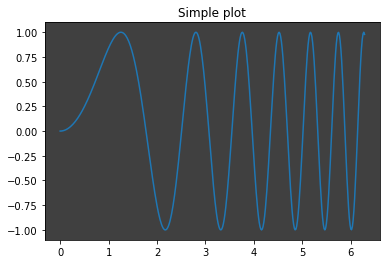

In [75]:
# First create some toy data:
x = numpy.linspace(0, 2*numpy.pi, 400)
y = numpy.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots() # Similar to ' data_proper, data_full_index = [], [] '
ax.plot(x, y)


ax.set_facecolor("0.25") # Dark-grey color


ax.set_title('Simple plot')
fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\1006734628.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed


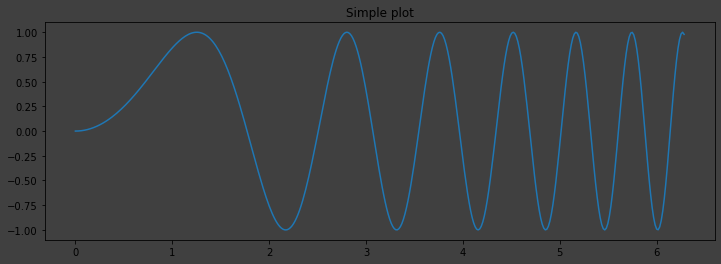

In [76]:
# First create some toy data:
x = numpy.linspace(0, 2*numpy.pi, 400)
y = numpy.sin(x**2)

# Create just a figure and only one subplot


fig, ax = plt.subplots(figsize = (12,4), facecolor = "0.25") # Similar to ' data_proper, data_full_index = [], [] '


ax.plot(x, y)
ax.set_facecolor("0.25") # Dark-grey color
ax.set_title('Simple plot')
fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\845756212.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed


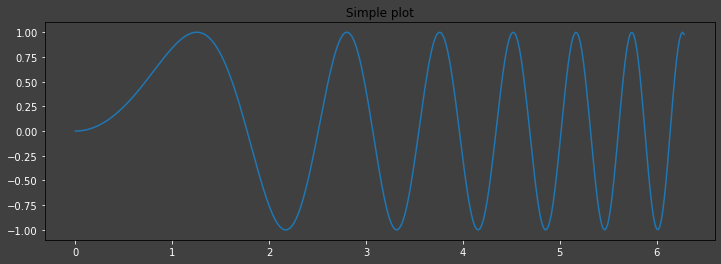

In [77]:
# First create some toy data:
x = numpy.linspace(0, 2*numpy.pi, 400)
y = numpy.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize = (12,4), facecolor = "0.25") # Similar to ' data_proper, data_full_index = [], [] '
ax.plot(x, y)
ax.set_facecolor("0.25") # Dark-grey color
ax.set_title('Simple plot')


ax.tick_params(axis = 'both', colors = 'w')


fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\3609707123.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed


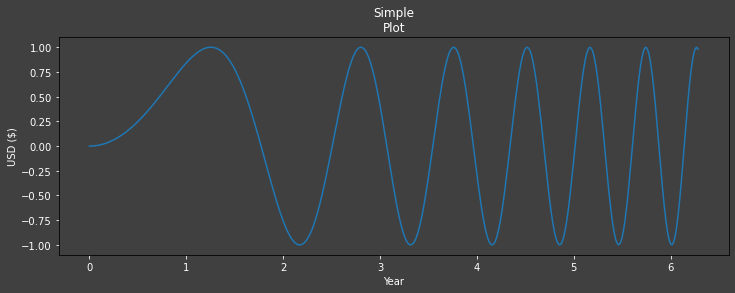

In [78]:
# First create some toy data:
x = numpy.linspace(0, 2*numpy.pi, 400)
y = numpy.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize = (12,4), facecolor = "0.25") # Similar to ' data_proper, data_full_index = [], [] '
ax.plot(x, y)
ax.set_facecolor("0.25") # Dark-grey color
ax.set_title('Simple plot')
ax.tick_params(axis = 'both', colors = 'w')


ax.set_title("Simple\nPlot", color = 'w')
plt.ylabel("USD ($)", color = 'w')
ax.set_xlabel("Year", color = 'w')

fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\3625192072.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed


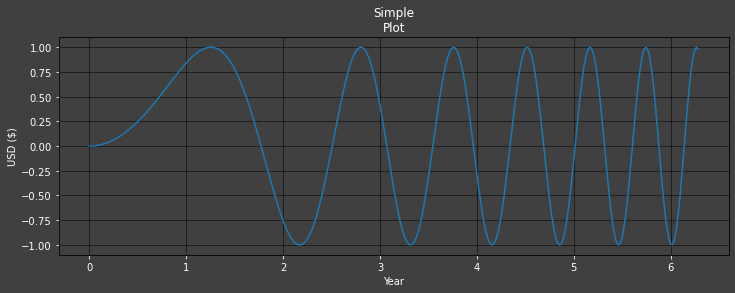

In [79]:
# First create some toy data:
x = numpy.linspace(0, 2*numpy.pi, 400)
y = numpy.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize = (12,4), facecolor = "0.25") # Similar to ' data_proper, data_full_index = [], [] '
ax.plot(x, y)
ax.set_facecolor("0.25") # Dark-grey color
ax.set_title('Simple plot')
ax.tick_params(axis = 'both', colors = 'w')
ax.set_title("Simple\nPlot", color = 'w')
plt.ylabel("USD ($)", color = 'w')
ax.set_xlabel("Year", color = 'w')


ax.grid(color = 'black', linewidth = 0.5)


fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed

In [80]:
start_date = pandas.DataFrame(df["GDP Component Sum (quarterly data)"].dropna()).iloc[:,[0]].index[0]
start_date

Timestamp('1959-02-01 00:00:00')

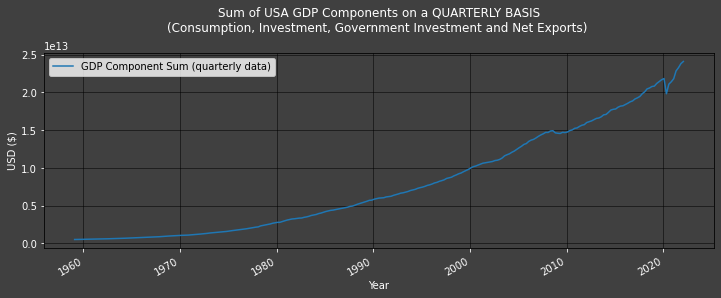

In [81]:
# ylabel = ""
# title = ""
# xlabel = "Year"
# datasubset = [0]
# datarange = False
# linescolor = False
# figuresize = (12,4)
# facecolor = "0.25"
# grid = True

dataset = pandas.DataFrame(df["GDP Component Sum (quarterly data)"].dropna())

start_date = str(dataset.iloc[:,[0]].index[0])
end_date = str(dataset.iloc[:,[0]].index[-1])

fig, ax1 = plt.subplots(figsize = (12,4), facecolor = "0.25") # "0.25" is a Dark-grey color
ax1.tick_params(axis = 'both', colors = 'w')
ax1.set_facecolor("0.25") # Dark-grey color
fig.autofmt_xdate()
plt.ylabel("USD ($)", color = 'w')
ax1.set_xlabel(str("Year"), color = 'w')

ax1.plot(dataset.iloc[:, 0].loc[start_date : end_date], label = str(dataset.columns[0]))

ax1.tick_params(axis = 'y')

ax1.grid(color = 'black', linewidth = 0.5)

ax1.set_title("Sum of USA GDP Components on a QUARTERLY BASIS\n(Consumption, Investment, Government Investment and Net Exports)" +
              " \n", color = 'w')
plt.legend()
plt.show()

No handles with labels found to put in legend.
C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\978941005.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed


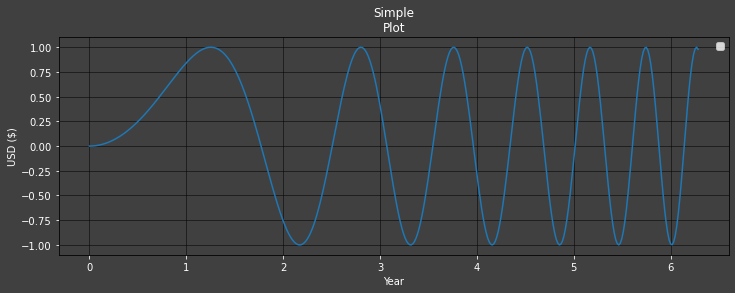

In [82]:
# First create some toy data:
x = numpy.linspace(0, 2*numpy.pi, 400)
y = numpy.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize = (12,4), facecolor = "0.25") # Similar to ' data_proper, data_full_index = [], [] '
ax.plot(x, y)
ax.set_facecolor("0.25") # Dark-grey color
ax.set_title('Simple plot')
ax.tick_params(axis = 'both', colors = 'w')
ax.set_title("Simple\nPlot", color = 'w')
plt.ylabel("USD ($)", color = 'w')
ax.set_xlabel("Year", color = 'w')
ax.grid(color = 'black', linewidth = 0.5)


plt.legend()


fig.show() # only here to stop ' Text(0.5, 1.0, 'Simple plot') ' from bieng printed

In [83]:
pandas.plotting.register_matplotlib_converters() # Using an implicitly registered datetime converter for a matplotlib plotting method is no longer supported by matplotlib. Current versions of pandas requires explicitly registering matplotlib converters.
def Plot1ax(dataset, ylabel = "", title = "", xlabel = "Year",
            datasubset = [0], datarange = False,
            linescolor = False, figuresize = (12,4),
            facecolor = "0.25", grid = True):
    """ Plot1ax Version 2.0:
    This function returns a Matplotlib graph with default colours and dimensions
    on one y axis (on the left as oppose to two, one on the left and one on the right).
    
    datasubset (list): Needs to be a list of the number of each column within
    the data-set that needs to be labelled on the left.
    
    datarange (bool): If wanting to plot graph from and to a specific point,
    make datarange a list of start and end date.
    
    linescolor (bool/list): (Default: False) This needs to be a list of the color of each
    vector to be ploted, in order they are shown in their dataframe from left to right.
    
    figuresize (tuple): (Default: (12,4)) This can be changed to give graphs of different
    proportions. It is defaulted to a 12 by 4 (ratioed) graph.
    
    facecolor (str): (Default: "0.25") This allows the user to change the
    background color as needed.
    
    grid (bool): (Default: "True") This allows us to decide wether or
    not to include a grid in our graphs.
    """
    
    # This function works if the dataset is specified in names of columns
    # or their placement (first column being the '0th').
    if type(datasubset[0]) == int:
        if datarange == False:
            start_date = str(dataset.iloc[:,datasubset].index[0])
            end_date = str(dataset.iloc[:,datasubset].index[-1])
        else:
            start_date = str(datarange[0])

            if datarange[-1] == -1:
                end_date = str(dataset.iloc[:,datasubset].index[-1])
            else:
                end_date = str(datarange[-1])
    else:
        if datarange == False:
            start_date = str(dataset[datasubset].index[0])
            end_date = str(dataset[datasubset].index[-1])
        else:
            start_date = str(datarange[0])

            if datarange[-1] == -1:
                end_date = str(dataset[datasubset].index[-1])
            else:
                end_date = str(datarange[-1])
        
    
    fig, ax1 = plt.subplots(figsize = figuresize, facecolor = facecolor)
    ax1.tick_params(axis = 'both', colors = 'w')
    ax1.set_facecolor(facecolor)
    fig.autofmt_xdate()
    plt.ylabel(ylabel, color = 'w')
    ax1.set_xlabel(str(xlabel), color = 'w')
    
    if type(datasubset[0]) == int:
        if linescolor == False:
            for i in datasubset: # This is to label all the lines in order to allow matplot lib to create a legend
                ax1.plot(dataset.iloc[:, i].loc[start_date : end_date],
                         label = str(dataset.columns[i]))
        else:
            for i in datasubset: # This is to label all the lines in order to allow matplot lib to create a legend
                ax1.plot(dataset.iloc[:, i].loc[start_date : end_date],
                         label = str(dataset.columns[i]),
                         color = linescolor)
    else:
        if linescolor == False:
            for i in datasubset: # This is to label all the lines in order to allow matplot lib to create a legend
                ax1.plot(dataset[i].loc[start_date : end_date],
                         label = i)
        else:
            for i in datasubset: # This is to label all the lines in order to allow matplot lib to create a legend
                ax1.plot(dataset[i].loc[start_date : end_date],
                         label = i,
                         color = linescolor)
    
    ax1.tick_params(axis = 'y')
    
    if grid == True:
        ax1.grid(color='black', linewidth = 0.5)
    
    ax1.set_title(str(title) + " \n", color = 'w')
    plt.legend()
    plt.show()

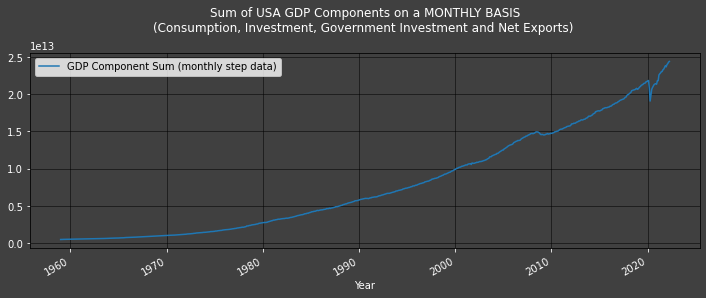

In [84]:
Plot1ax(dataset = pandas.DataFrame(df["GDP Component Sum (monthly step data)"].dropna()),
        title = "Sum of USA GDP Components on a MONTHLY BASIS\n(Consumption, Investment, Government Investment and Net Exports)")

$$ \\ $$
### [U.S.A.'s G.D.P.](http://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=USGDP...B&prev=99_USA+GDP&nav_category=12)

To check our model, we can use ['United States, National Product Account, Gross Domestic Product, Overall, Total, Current Prices, AR, SA, USD'](http://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=USGDP...B&prev=99_USA+GDP&nav_category=12).

In [85]:
Add_to_df(data = ds.get_data(tickers = 'USGDP...B',
                             fields = "X",
                             start = '1950-02-01',
                             freq = 'M') * 1000000000,
          dataname = "GDP (every quarter)")

In [86]:
df["GDP (monthly step data)"] = Quarterly_To_Monthly(data = df["GDP (every quarter)"],
                                                     dataname = "GDP (monthly step data)").dropna()
df["GDP (monthly step data)"]

1950-02-01    2.808280e+11
1950-03-01    2.808280e+11
1950-04-01    2.808280e+11
1950-05-01    2.903830e+11
1950-06-01    2.903830e+11
                  ...     
2022-06-01             NaN
2022-07-01             NaN
2022-08-01             NaN
2022-09-01             NaN
2022-10-01             NaN
Name: GDP (monthly step data), Length: 873, dtype: float64

$$ \\ $$
### Data Résumé

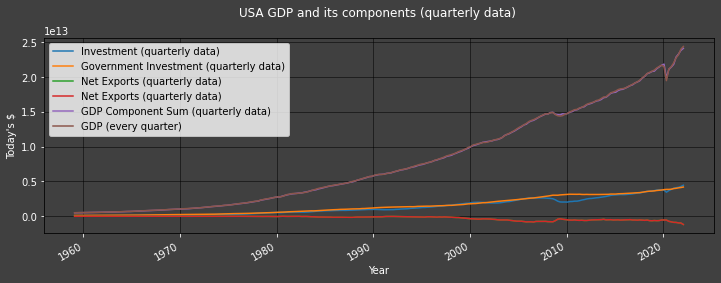

In [87]:
Plot1ax(title = "USA GDP and its components (quarterly data)",
        dataset = df.dropna(), ylabel = "Today's $",
        datasubset = ["Investment (quarterly data)",
                      "Government Investment (quarterly data)",
                      "Net Exports (quarterly data)",
                      "Net Exports (quarterly data)",
                      "GDP Component Sum (quarterly data)",
                      "GDP (every quarter)"])

Note that the GDP and GDP Component Sum datapoints align so well that they are indistinguishable in the graph above

$$ \\ $$
# Part 5: The [Holt-Winters (HW) method](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1) for Positive Data

In [88]:
help(statsmodels.tsa.holtwinters.ExponentialSmoothing)

Help on class ExponentialSmoothing in module statsmodels.tsa.holtwinters.model:

class ExponentialSmoothing(statsmodels.tsa.base.tsa_model.TimeSeriesModel)
 |  ExponentialSmoothing(endog, trend=None, damped_trend=False, seasonal=None, *, seasonal_periods=None, initialization_method=None, initial_level=None, initial_trend=None, initial_seasonal=None, use_boxcox=None, bounds=None, dates=None, freq=None, missing='none')
 |  
 |  Holt Winter's Exponential Smoothing
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The time series to model.
 |  trend : {"add", "mul", "additive", "multiplicative", None}, optional
 |      Type of trend component.
 |  damped_trend : bool, optional
 |      Should the trend component be damped.
 |  seasonal : {"add", "mul", "additive", "multiplicative", None}, optional
 |      Type of seasonal component.
 |  seasonal_periods : int, optional
 |      The number of periods in a complete seasonal cycle, e.g., 4 for
 |      quarterly data or 7 for dai

In [89]:
invest_model_fit = statsmodels.tsa.holtwinters.ExponentialSmoothing(endog = df["Investment (monthly step data)"].dropna(),
                                                                    seasonal_periods = 12,
                                                                    trend = 'add',
                                                                    damped = True).fit(use_boxcox = True)

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\284071339.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  invest_model_fit = statsmodels.tsa.holtwinters.ExponentialSmoothing(endog = df["Investment (monthly step data)"].dropna(),
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model i

In [90]:
df1 = pandas.DataFrame([])
df1["Investment fitted values (monthly step data)"] = invest_model_fit.fittedvalues
df1

,Investment fitted values (monthly step data)
1950-02-01,4.376023e+10
1950-03-01,4.583060e+10
1950-04-01,4.638194e+10
1950-05-01,4.614662e+10
1950-06-01,4.931721e+10
...,...
2021-12-01,4.264310e+12
2022-01-01,4.302994e+12
2022-02-01,4.311818e+12
2022-03-01,4.444134e+12


In [91]:
invest_model_fit.forecast(3)

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2022-05-01    4.513726e+12
2022-06-01    4.546315e+12
2022-07-01    4.575756e+12
Freq: MS, dtype: float64

In [92]:
df1["Investment forecasts (monthly step data)"] = invest_model_fit.forecast(3)
df1

,Investment fitted values (monthly step data),Investment forecasts (monthly step data)
1950-02-01,4.376023e+10,NaN
1950-03-01,4.583060e+10,NaN
1950-04-01,4.638194e+10,NaN
1950-05-01,4.614662e+10,NaN
1950-06-01,4.931721e+10,NaN
...,...,...
2021-12-01,4.264310e+12,NaN
2022-01-01,4.302994e+12,NaN
2022-02-01,4.311818e+12,NaN
2022-03-01,4.444134e+12,NaN


In [93]:
# Add nan to df 1:
numpy.nan

nan

In [94]:
# Add nan to df 2:
df1 = df1.append(pandas.DataFrame([[numpy.nan, numpy.nan]],
                            columns = df1.columns,
                            index = [df1.index[-1] + dateutil.relativedelta.relativedelta(months =+ 1)]))
df1

,Investment fitted values (monthly step data),Investment forecasts (monthly step data)
1950-02-01,4.376023e+10,NaN
1950-03-01,4.583060e+10,NaN
1950-04-01,4.638194e+10,NaN
1950-05-01,4.614662e+10,NaN
1950-06-01,4.931721e+10,NaN
...,...,...
2022-01-01,4.302994e+12,NaN
2022-02-01,4.311818e+12,NaN
2022-03-01,4.444134e+12,NaN
2022-04-01,4.502334e+12,NaN


In [95]:
# Add nan to df 3:
pandas.DataFrame([[numpy.nan, numpy.nan]],
                 columns = df1.columns,
                 index = [df1.index[-1] + dateutil.relativedelta.relativedelta(months =+ 1)])

,Investment fitted values (monthly step data),Investment forecasts (monthly step data)
2022-06-01,NaN,NaN


In [96]:
df1["Investment forecasts (monthly step data)"] = invest_model_fit.forecast(1)
# df1["Investment fitted values' real errors (monthly step data)"] = df1["Investment fitted values (monthly step data)"] - df["Investment (monthly step data)"]
df1

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,Investment fitted values (monthly step data),Investment forecasts (monthly step data)
1950-02-01,4.376023e+10,NaN
1950-03-01,4.583060e+10,NaN
1950-04-01,4.638194e+10,NaN
1950-05-01,4.614662e+10,NaN
1950-06-01,4.931721e+10,NaN
...,...,...
2022-01-01,4.302994e+12,NaN
2022-02-01,4.311818e+12,NaN
2022-03-01,4.444134e+12,NaN
2022-04-01,4.502334e+12,NaN


In [97]:
for i in range(2):
    df1 = df1.append(pandas.DataFrame([[numpy.nan, numpy.nan]], columns = df1.columns,
                                      index = [df1.index[-1] + dateutil.relativedelta.relativedelta(months =+ 1)]))
df1["Investment forecasts (monthly step data)"] = invest_model_fit.forecast(3) # Notice that it's 3 here but 2 in the range function above since we already appended df1 with 1 forecast.
df1

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,Investment fitted values (monthly step data),Investment forecasts (monthly step data)
1950-02-01,4.376023e+10,NaN
1950-03-01,4.583060e+10,NaN
1950-04-01,4.638194e+10,NaN
1950-05-01,4.614662e+10,NaN
1950-06-01,4.931721e+10,NaN
...,...,...
2022-03-01,4.444134e+12,NaN
2022-04-01,4.502334e+12,NaN
2022-05-01,NaN,4.513726e+12
2022-06-01,NaN,4.546315e+12


In [98]:
Statistics_Table = pandas.DataFrame(columns = ["Mean", "Mean of Absolute Values",
                                               "Standard Deviation",
                                               "Median", "Skewness",
                                               "Kurtosis",
                                               "Single Period Growth Geometric Average"],
                                    index = [c for c in df1.columns])
Statistics_Table

,Mean,Mean of Absolute Values,Standard Deviation,Median,Skewness,Kurtosis,Single Period Growth Geometric Average
Investment fitted values (monthly step data),NaN,NaN,NaN,NaN,NaN,NaN,NaN
Investment forecasts (monthly step data),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
df1.columns

Index(['Investment fitted values (monthly step data)', 'Investment forecasts (monthly step data)'], dtype='object')

In [100]:
df1.columns[0]

'Investment fitted values (monthly step data)'

In [101]:
df1[df1.columns[0]]

1950-02-01    4.376023e+10
1950-03-01    4.583060e+10
1950-04-01    4.638194e+10
1950-05-01    4.614662e+10
1950-06-01    4.931721e+10
                  ...     
2022-03-01    4.444134e+12
2022-04-01    4.502334e+12
2022-05-01             NaN
2022-06-01             NaN
2022-07-01             NaN
Name: Investment fitted values (monthly step data), Length: 870, dtype: float64

In [102]:
df1[str(df1.columns[0])].dropna()

1950-02-01    4.376023e+10
1950-03-01    4.583060e+10
1950-04-01    4.638194e+10
1950-05-01    4.614662e+10
1950-06-01    4.931721e+10
                  ...     
2021-12-01    4.264310e+12
2022-01-01    4.302994e+12
2022-02-01    4.311818e+12
2022-03-01    4.444134e+12
2022-04-01    4.502334e+12
Name: Investment fitted values (monthly step data), Length: 867, dtype: float64

In [103]:
numpy.mean(df1[str(str(df1.columns[0]))].dropna())

1191556369949.618

In [104]:
Statistics_Table["Mean"][str(df1.columns[0])] = numpy.mean(df1[str(str(df1.columns[0]))].dropna())

In [105]:
Statistics_Table

,Mean,Mean of Absolute Values,Standard Deviation,Median,Skewness,Kurtosis,Single Period Growth Geometric Average
Investment fitted values (monthly step data),1191556369949.61792,NaN,NaN,NaN,NaN,NaN,NaN
Investment forecasts (monthly step data),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
Statistics_Table["Mean of Absolute Values"][str(df1.columns[0])] = numpy.mean(abs(df1[str(str(df1.columns[0]))].dropna()))
Statistics_Table

,Mean,Mean of Absolute Values,Standard Deviation,Median,Skewness,Kurtosis,Single Period Growth Geometric Average
Investment fitted values (monthly step data),1191556369949.61792,1191556369949.61792,NaN,NaN,NaN,NaN,NaN
Investment forecasts (monthly step data),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
for c in df1.columns:
    Statistics_Table["Mean"][str(c)] = numpy.mean(df1[str(c)].dropna())
    Statistics_Table["Mean of Absolute Values"][str(c)] = numpy.mean(abs(df1[str(c)].dropna()))
    Statistics_Table["Standard Deviation"][str(c)] = numpy.std(df1[str(c)].dropna())
    Statistics_Table["Median"][str(c)] = numpy.median(df1[str(c)].dropna())
    Statistics_Table["Skewness"][str(c)] = scipy.stats.skew(df1[str(c)].dropna())
    Statistics_Table["Kurtosis"][str(c)] = scipy.stats.kurtosis(df1[str(c)].dropna())

#     if len(df1[str(c)].dropna()) != 1 or df1[str(c)].dropna()[0] != 0: # This if statement is needed in case we end up asking for the computation of a value divided by 0.
#         Statistics_Table["Single Period Growth Geometric Average"][str(c)] = Single_period_Geometric_Growth(df1[str(c)].dropna())

In [108]:
Statistics_Table

,Mean,Mean of Absolute Values,Standard Deviation,Median,Skewness,Kurtosis,Single Period Growth Geometric Average
Investment fitted values (monthly step data),1191556369949.61792,1191556369949.61792,1167804030185.279785,836172559975.116089,0.847631,-0.443133,NaN
Investment forecasts (monthly step data),4545265745985.518555,4545265745985.518555,25334295064.549885,4546314803638.521484,-0.062042,-1.5,NaN


In [109]:
def Statistics_Table(dataset1, dataset2 = ""):
    
    Statistics_Table_Columns = list(dataset1.columns)
    
    if str(dataset2) != "":
        [Statistics_Table_Columns.append(str(i)) for i in dataset2.columns]
    
    Statistics_Table = pandas.DataFrame(columns = ["Mean", "Mean of Absolute Values",
                                                   "Standard Deviation",
                                                   "Median", "Skewness",
                                                   "Kurtosis",
                                                   "Single Period Growth Geometric Average"],
                                        index = [c for c in Statistics_Table_Columns])
    
    def Statistics_Table_function(data):
        for c in data.columns:
            Statistics_Table["Mean"][str(c)] = numpy.mean(data[str(c)].dropna())
            Statistics_Table["Mean of Absolute Values"][str(c)] = numpy.mean(abs(data[str(c)].dropna()))
            Statistics_Table["Standard Deviation"][str(c)] = numpy.std(data[str(c)].dropna())
            Statistics_Table["Median"][str(c)] = numpy.median(data[str(c)].dropna())
            Statistics_Table["Skewness"][str(c)] = scipy.stats.skew(data[str(c)].dropna())
            Statistics_Table["Kurtosis"][str(c)] = scipy.stats.kurtosis(data[str(c)].dropna())
            
#             if len(data[str(c)].dropna()) != 1 or data[str(c)].dropna()[0] != 0: # This if statement is needed in case we end up asking for the computation of a value divided by 0.
#                 Statistics_Table["Single Period Growth Geometric Average"][str(c)] = Single_period_Geometric_Growth(data[str(c)].dropna())
    
    Statistics_Table_function(dataset1)
    
    if str(dataset2) != "":
        Statistics_Table_function(dataset2)
    
    return Statistics_Table

In [110]:
Statistics_Table(dataset1 = df1)

,Mean,Mean of Absolute Values,Standard Deviation,Median,Skewness,Kurtosis,Single Period Growth Geometric Average
Investment fitted values (monthly step data),1191556369949.61792,1191556369949.61792,1167804030185.279785,836172559975.116089,0.847631,-0.443133,NaN
Investment forecasts (monthly step data),4545265745985.518555,4545265745985.518555,25334295064.549885,4546314803638.521484,-0.062042,-1.5,NaN


$$ \\ $$
# Part 6: The [Holt-Winters (HW) method](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1) for Negative Data

In [111]:
# model_fit = statsmodels.tsa.holtwinters.ExponentialSmoothing(df["Net Exports (monthly step data)"].dropna(),
#                                                              seasonal_periods = 12,
#                                                              trend = 'add',
#                                                              damped = True).fit(use_boxcox = True)

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\76314078.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model_fit = statsmodels.tsa.holtwinters.ExponentialSmoothing(df["Net Exports (monthly step data)"].dropna(),
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.


ValueError: Data must be positive.

In [112]:
# First: we need to note that the Holt-Winters model only works for positive datasets.
# the following is to account for negative values:
_data_min_p1 = numpy.absolute(pandas.DataFrame.min(df["Net Exports (monthly step data)"])) + 1
_data = (_data_min_p1 + df["Net Exports (monthly step data)"].copy()).dropna()

df1["Net Exports (monthly step data) positive"] = _data

In [113]:
df1

,Investment fitted values (monthly step data),Investment forecasts (monthly step data),Net Exports (monthly step data) positive
1950-02-01,4.376023e+10,NaN,1.180107e+12
1950-03-01,4.583060e+10,NaN,1.180107e+12
1950-04-01,4.638194e+10,NaN,1.180107e+12
1950-05-01,4.614662e+10,NaN,1.179547e+12
1950-06-01,4.931721e+10,NaN,1.179547e+12
...,...,...,...
2022-03-01,4.444134e+12,NaN,1.000000e+00
2022-04-01,4.502334e+12,NaN,1.000000e+00
2022-05-01,NaN,4.513726e+12,NaN
2022-06-01,NaN,4.546315e+12,NaN


In [114]:
model_fit = statsmodels.tsa.holtwinters.ExponentialSmoothing(_data.dropna(),
                                                             seasonal_periods = 12,
                                                             trend = 'add',
                                                             damped = True).fit(use_boxcox = True)

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\1270835663.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model_fit = statsmodels.tsa.holtwinters.ExponentialSmoothing(_data.dropna(),
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
c:\users\u608

In [115]:
model_fit.fittedvalues

1950-02-01    1.180107e+12
1950-03-01    1.180107e+12
1950-04-01    1.180107e+12
1950-05-01    1.180107e+12
1950-06-01    1.179551e+12
                  ...     
2021-12-01    1.970087e+11
2022-01-01    1.965949e+11
2022-02-01    1.969034e+11
2022-03-01             NaN
2022-04-01             NaN
Length: 867, dtype: float64

In [116]:
df1["Net Exports fitted values (monthly step data)"] = model_fit.fittedvalues - _data_min_p1
df1["Net Exports forecasts (monthly step data)"] = model_fit.forecast(3) - _data_min_p1
df1["Net Exports fitted values' real errors (monthly step data)"] = df1["Net Exports fitted values (monthly step data)"] - df["Net Exports (monthly step data)"]
df1

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,Investment fitted values (monthly step data),Investment forecasts (monthly step data),Net Exports (monthly step data) positive,Net Exports fitted values (monthly step data),Net Exports forecasts (monthly step data),Net Exports fitted values' real errors (monthly step data)
1950-02-01,4.376023e+10,NaN,1.180107e+12,2.203000e+09,NaN,1.708984e-03
1950-03-01,4.583060e+10,NaN,1.180107e+12,2.203000e+09,NaN,1.708984e-03
1950-04-01,4.638194e+10,NaN,1.180107e+12,2.203000e+09,NaN,1.708984e-03
1950-05-01,4.614662e+10,NaN,1.179547e+12,2.203000e+09,NaN,5.600000e+08
1950-06-01,4.931721e+10,NaN,1.179547e+12,1.646544e+09,NaN,3.544005e+06
...,...,...,...,...,...,...
2022-03-01,4.444134e+12,NaN,1.000000e+00,NaN,NaN,NaN
2022-04-01,4.502334e+12,NaN,1.000000e+00,NaN,NaN,NaN
2022-05-01,NaN,4.513726e+12,NaN,NaN,NaN,NaN
2022-06-01,NaN,4.546315e+12,NaN,NaN,NaN,NaN


### Holt Winters models and graphs

In [117]:
# See the HW model's forecasts:
print("Investment forecasts:")
display(invest_model_fit.forecast(3))

Investment forecasts:


c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2022-05-01    4.513726e+12
2022-06-01    4.546315e+12
2022-07-01    4.575756e+12
Freq: MS, dtype: float64

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


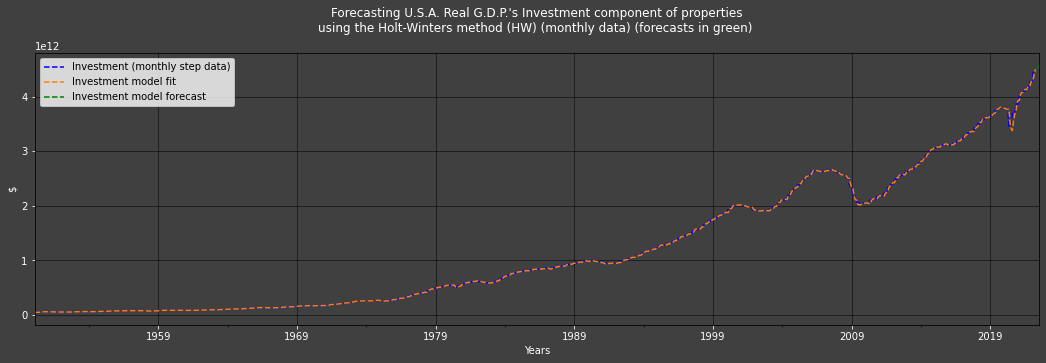

In [118]:
# Plot the newly created Exponential Smoothing data
fig1, ax1 = plt.subplots(figsize = (18,5), facecolor = "0.25")
df["Investment (monthly step data)"].dropna().plot(style = "--",
                                                color = "blue",
                                                legend = True).legend(["Investment (monthly step data)"])

invest_model_fit.fittedvalues.plot(style = "--",
                            color = "C1",
                            label = "Investment model fit",
                            legend = True)

invest_model_fit.forecast(3).plot(style = "--",
                           color = "green",
                           label = "Investment model forecast",
                           legend = True)

ax1.set_facecolor("0.25")
ax1.tick_params(axis = "both", colors = "w")
plt.ylabel("$", color = "w")
ax1.set_xlabel("Years", color = "w")
ax1.grid(color = 'black', linewidth = 0.5)

ax1.set_title("Forecasting U.S.A. Real G.D.P.'s " + "Investment component of properties" +
              "\nusing the Holt-Winters method (HW) (monthly data) (forecasts in " +
              "green" + ") \n", color='w')

ax1.legend()
plt.show()

In [119]:
def Holt_Winters_Method(name, forecast_period = 3, negative_accounting = False, silence_warings = True,
                       figure_size = (15,4), face_color = "0.25", point_style = "-", plot_color = "blue",
                       fitted_point_style = "-", fitted_point_color = "C1", xlabel = "Years",
                       forecasted_point_style = "-", forecasted_point_color = "#328203"):
    """ This function was created specifically for this script/article. It uses the Holt-Winters
    method to construct estimates and forecasts, adds it to ' df 'and plots the original data against
    the estimates and forecasts.
    Necessitates the function ' Quarterly_To_Monthly '
    
    name (str): Name of the GDP component in question. This component must be included in ' df '.
    
    forecast_period (int): Set to ' 3 ' as default. Number of periods we wish to display forecasts for.
    
    negative_accounting (bool): Set to False by default. If set to True, this accounts for negative values
    in that it does not display forecasted values explicitly or the graph because they would be shifted up.
    
    figure_size, face_color, point_style, plot_color, fitted_point_style, fitted_point_color, xlabel,
    forecasted_point_style, and forecasted_point_color are variables to modify the plot returned.
    """
    global df # we are not defining our df function inside the ' Holt_Winters_Method ' (e.g.: df = pandas.DataFrame([])); instead we are using the one constructed outside the function.
    
    if negative_accounting == True:
        # First: we need to note that the Holt-Winters model only works for positive datasets.
        # the following is to account for negative values:
        _data_min_p1 = numpy.absolute(pandas.DataFrame.min(df[name + " (monthly step data)"])) + 1
        _data = (_data_min_p1 + df[name + " (monthly step data)"].copy()).dropna()
        
        df[name + " (monthly step data) positive"] = _data
    else:
        _data_min_p1 = 0
        _data = df[name + " (monthly step data)"].dropna()
    
    if silence_warings == True:
        # The following will throw errors informing us that the unspecified Holt-Winters Exponential Smoother
        # parameters will be chosen by the default ' statsmodels.tsa.api.ExponentialSmoothing ' optimal ones.
        # This is preferable and doesn't need to be stated for each iteration in the loop.
        warnings.simplefilter("ignore")
    
    model_fit = statsmodels.tsa.holtwinters.ExponentialSmoothing(_data.dropna(),
                                                                 seasonal_periods = 12,
                                                                 trend = 'add',
                                                                 damped = True).fit(use_boxcox = True)
    
    df[name + " fitted values (monthly step data)"] = model_fit.fittedvalues - _data_min_p1
    df[name + " forecasts (monthly step data)"] = model_fit.forecast(forecast_period) - _data_min_p1
    df[name + " fitted values' real errors (monthly step data)"] = df[name + " fitted values (monthly step data)"] - df[name + " (monthly step data)"]
    
    if negative_accounting == False:
        # See the HW model's forecasts:
        print(name + " forecasts:")
        display(model_fit.forecast(forecast_period))
        
        
        # Plot the newly created Exponential Smoothing data
        fig1, ax1 = plt.subplots(figsize = figure_size, facecolor = face_color)
        df[name + " (monthly step data)"].dropna().plot(style = point_style,
                                                        color = plot_color,
                                                        legend = True).legend([name + " (monthly step data)"])
        
        model_fit.fittedvalues.plot(style = fitted_point_style,
                                    color = fitted_point_color,
                                    label = name + " model fit",
                                    legend = True)
        
        model_fit.forecast(forecast_period).plot(style = forecasted_point_style,
                                                 color = forecasted_point_color,
                                                 label = name + " model forecast",
                                                 legend = True)
        
        ax1.set_facecolor(face_color)
        ax1.tick_params(axis = "both", colors = "w")
        plt.ylabel("Ratio", color = "w")
        ax1.set_xlabel(xlabel, color = "w")
        ax1.grid(color='black', linewidth = 0.5)
        
        # The default 'forecasted_point_color' is "#328203", i.e.: green
        if forecasted_point_color == "#328203":
            ax1.set_title("Forecasting USA Real GDP's "+ name + " component of properties" +
                      "\nusing the Holt-Winters method (HW) (monthly data) (forecasts in green)" +
                      " \n", color='w')
        else:
            ax1.set_title("Forecasting U.S.A. Real G.D.P.'s "+ name + " component of properties" +
                          "\nusing the Holt-Winters method (HW) (monthly data) (forecasts in " +
                          forecasted_point_color + ") \n", color = 'w')

        ax1.legend()
        plt.show()
    
    if silence_warings == True:
        # We want our program to let us know of warnings from now on; they were only disabled for the for loop above.
        warnings.simplefilter("default")

Investment forecasts:


2022-05-01    4.513726e+12
2022-06-01    4.546315e+12
2022-07-01    4.575756e+12
Freq: MS, dtype: float64

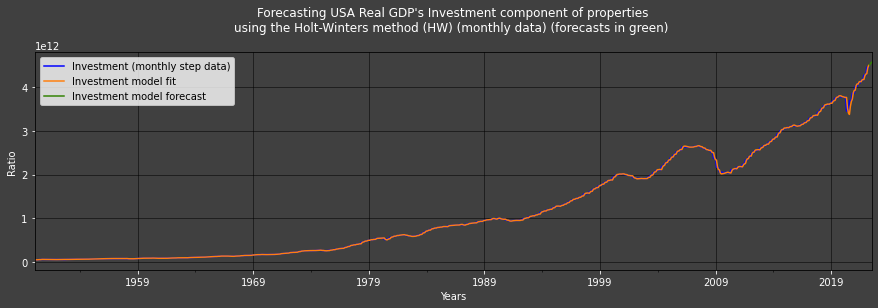

In [120]:
Holt_Winters_Method(name = "Investment")

In [121]:
# the ' pandas.DataFrame ' here is only there to make Jupyter return a Markdown table that looks better than the raw ' print ' output.
pandas.DataFrame(Statistics_Table(dataset1 = df).loc[["Investment forecasts (monthly step data)",
                                                      "Investment fitted values' real errors (monthly step data)"]]["Mean of Absolute Values"])

,Mean of Absolute Values
Investment forecasts (monthly step data),4545265745985.518555
Investment fitted values' real errors (monthly step data),9728974069.553205


Government Investment forecasts:


2022-05-01    4.224740e+12
2022-06-01    4.240523e+12
2022-07-01    4.255927e+12
Freq: MS, dtype: float64

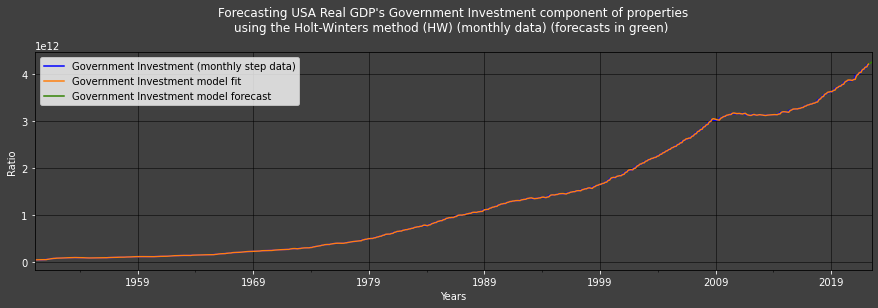

In [122]:
Holt_Winters_Method(name = "Government Investment")

In [123]:
Holt_Winters_Method(name = "Net Exports", negative_accounting = True)

$$ \\ $$
# Part 7: Back-testing our Method

$$ \\ $$
We will back-test our models from January 2007

In [124]:
start = "2007-01-01"

In [125]:
datetime.datetime.strptime(start, "%Y-%m-%d")

datetime.datetime(2007, 1, 1, 0, 0)

In [126]:
str(datetime.datetime.strptime(start, "%Y-%m-%d"))

'2007-01-01 00:00:00'

In [127]:
datetime.datetime.strptime(start, "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months=+1)

datetime.datetime(2007, 2, 1, 0, 0)

In [128]:
str(datetime.datetime.strptime(start, "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months=+1))

'2007-02-01 00:00:00'

In [129]:
str(datetime.datetime.strptime(start, "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months=+1))[:10]

'2007-02-01'

In [130]:
start_plus_1 = str(datetime.datetime.strptime(start, "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months=+1))[:10]

In [131]:
HWES1 = statsmodels.tsa.holtwinters.ExponentialSmoothing(
    df["Investment (monthly step data)"].dropna().loc[:pandas.Timestamp(start_plus_1)],
    trend = 'add',
    seasonal_periods = 12,
    damped = True).fit(use_boxcox = True).forecast(1)

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\3495013076.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  HWES1 = statsmodels.tsa.holtwinters.ExponentialSmoothing(
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
c:\users\u6082174.ten\appdata\lo

In [132]:
HWES1

2007-03-01    2.640122e+12
Freq: MS, dtype: float64

`.forecast(1)` was there to express taht we're only doing one forecast, one step ahead. We could do 2:

In [133]:
HWES1_2 = statsmodels.tsa.holtwinters.ExponentialSmoothing(
    df["Investment (monthly step data)"].dropna().loc[:pandas.Timestamp(start_plus_1)],
    trend = 'add',
    seasonal_periods = 12,
    damped = True).fit(use_boxcox = True).forecast(2)
HWES1_2

C:\Users\U6082174\AppData\Local\Temp\ipykernel_25904\1978026487.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  HWES1_2 = statsmodels.tsa.holtwinters.ExponentialSmoothing(


2007-03-01    2.640122e+12
2007-04-01    2.642682e+12
Freq: MS, dtype: float64

But we're interested only in single step ahead forecasts since if we were to forecast values for in two period's time, we would not include data in one time period's time, which we'll get simpl;y by waiting. So we're better off waiting, seeing the realisation of the data and including it in our model.

Let's do this again for the next forecast, but try and not get thiswarning message:

In [134]:
# The following for loop will throw errors informing us that the unspecified Holt-Winters
#    Exponential Smoother parameters will be chosen by the default
#    ' statsmodels.tsa.holtwinters.ExponentialSmoothing ' optimal ones. This is preferable and
#    doesn't need to be stated for each iteration in the loop.
warnings.simplefilter("ignore")

In [135]:
start_plus_2 = str(datetime.datetime.strptime(start, "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months=+2))[:10]

In [136]:
HWES2 = statsmodels.tsa.holtwinters.ExponentialSmoothing(
    df["Investment (monthly step data)"].dropna().loc[:pandas.Timestamp(start_plus_2)],
    trend = 'add',
    seasonal_periods = 12,
    damped = True).fit(use_boxcox = True).forecast(1)

In [137]:
HWES2

2007-04-01    2.644753e+12
Freq: MS, dtype: float64

Let's do it all together:

In [138]:
float(str(HWES2)[14:-25])

2644753000000.0

In [139]:
HWES2.values[0]

2644752715678.193

In [140]:
str(HWES2)[:10]

'2007-04-01'

In [141]:
# The following for loop will throw errors informing us that the unspecified Holt-Winters
# Exponential Smoother parameters will be chosen by the default
# ' statsmodels.tsa.holtwinters.ExponentialSmoothing ' optimal ones. This is preferable and
# doesn't need to be stated for each iteration in the loop.
warnings.simplefilter("ignore")

# We create an empty list (toget appended/populated) for our dataset's forecast using the
# Holt-Winters exponential smoother and to be populated by our forecasts (in- or out-of-sample)
data_model_in_sample_plus_one_forecast, value, index = [], [], []

# the ' len(...) ' function here returns the number of rows in our dataset from our starting date till its end.
for i in range(0, len(df["Investment (monthly step data)"].loc[pandas.Timestamp(start):].dropna())):

    # This line deffines ' start_plus_i ' as our starting date plus i months
    start_plus_i = str(
        datetime.datetime.strptime(start, "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months=+i))[:10]

    HWESi = statsmodels.tsa.holtwinters.ExponentialSmoothing(
        df["Investment (monthly step data)"].dropna().loc[:pandas.Timestamp(start_plus_i)],
        trend='add',
        seasonal_periods=12,
        damped=True).fit(use_boxcox=True).forecast(1)

    # This outputs a forecast for one period ahead (whether in-sample or out of sample). Since we start at i = 0, this line provides a HW forecast for i at 1;
    # simillarly, at the last i (say T), it provides the first and only out-of-sample forecast (where i = T+1).
    data_model_in_sample_plus_one_forecast.append(HWESi)

    # Sometimes the H-W model comes up with extreme estimates, a cap can account for that:
    if HWESi.values[0] > 1.1:
        value.append(float(HWESi.values[0]))
    else:
        value.append(numpy.nan) # If the ratio

    index.append(datetime.datetime.strptime(str(HWESi)[:10], "%Y-%m-%d"))

# We want our program to let us know of warnings from now on; they were only disabled for the for loop above.
warnings.simplefilter("default")

_df = pandas.DataFrame(data=value, index=index, columns=["Investment model in sample plus one forecast"])

In [142]:
_df

,Investment model in sample plus one forecast
2007-02-01,2.631455e+12
2007-03-01,2.640122e+12
2007-04-01,2.644753e+12
2007-05-01,2.646282e+12
2007-06-01,2.656402e+12
...,...
2022-01-01,4.302957e+12
2022-02-01,4.311558e+12
2022-03-01,4.444235e+12
2022-04-01,4.502672e+12


The Python function defined in the cell below returns the In-Sample Recursive Prediction values of ' data ' using the Holt-Winters exponential smoother Plus it then provides forecasts for One Out-Of-Sample period (thus the acronym 'ISRPHWPOOOF'):

In [143]:
def ISRPHWPOOOF(data_set, dataset_name, start, result_name, enforce_cap = False, cap = 1.1):
    """ ISRPHWPOOOF Version 3.0:

    data_set (pandas dataset): dataframe where the data is stored

    dataset_name (str): Our data is likely to be in a pandas dataframe with dates for
    indexes in order to eleviate any date sinking issues. As a result, this line allows
    the user to specify the column within such a dataset to use.

    start (str): The start of our in-sample recursive prediction window. e.g.: "1990-01-01".
    This value can be changed.

    enforce_cap (bool): Set to False by delault.

    cap (int/float): Set to ' 1.1 ' by default.
    """

    # The following for loop will throw errors informing us that the unspecified Holt-Winters
    # Exponential Smoother parameters will be chosen by the default
    # ' statsmodels.tsa.holtwinters.ExponentialSmoothing ' optimal ones. This is preferable and
    # doesn't need to be stated for each iteration in the loop.
    warnings.simplefilter("ignore")

    # We create an empty list (toget appended/populated) for our dataset's forecast using the
    # Holt-Winters exponential smoother and to be populated by our forecasts (in- or out-of-sample)
    data_model_in_sample_plus_one_forecast, value, index = [], [], []

    # the ' len(...) ' function here returns the number of rows in our dataset from our starting date till its end.
    for i in range(0, len(data_set[dataset_name].loc[pandas.Timestamp(start):].dropna())):

        # This line deffines ' start_plus_i ' as our starting date plus i months
        start_plus_i = str(
            datetime.datetime.strptime(start, "%Y-%m-%d") + dateutil.relativedelta.relativedelta(months=+i))[:10]

        HWESi = statsmodels.tsa.holtwinters.ExponentialSmoothing(
            data_set[dataset_name].dropna().loc[:pandas.Timestamp(start_plus_i)],
            trend = 'add',
            seasonal_periods = 12,
            damped = True).fit(use_boxcox = True).forecast(1)

        # This outputs a forecast for one period ahead (whether in-sample or out of sample). Since we start at i = 0, this line provides a HW forecast for i at 1;
        # simillarly, at the last i (say T), it provides the first and only out-of-sample forecast (where i = T+1).
        data_model_in_sample_plus_one_forecast.append(HWESi)

        try:
            # Sometimes the H-W model comes up with extreme estimates, a cap can account for that:
            if enforce_cap == True:
                if float(str(HWESi)[14:-25]) > cap:
                    value.append(float(str(HWESi)[14:-25]))
                else:
                    value.append(numpy.nan) # If the ratio
            else:
                value.append(float(str(HWESi)[14:-25]))

        except:
            # This adds NaN (Not a Number) to the list ' values ' if there is no value to add.
            # The statsmodels.tsa.api.ExponentialSmoothing function sometimes (rarely) outputs NaNs.
            value.append(numpy.nan)
        finally:
            # This adds our indecies (dates) to the list ' index '
            index.append(datetime.datetime.strptime(str(HWESi)[:10], "%Y-%m-%d"))

    # We want our program to let us know of warnings from now on; they were only disabled for the for loop above.
    warnings.simplefilter("default")

    return pandas.DataFrame(data = value, index = index, columns = [result_name])

$$ \\ $$
### Back-testing our Method with Investment data
$$ \\ $$
We will back-test our models from January 2007

In [144]:
start = "2007-01-01"

In [145]:
# Model:
Investment_model_in_sample_plus_one_forecast = ISRPHWPOOOF(
    data_set=df,
    dataset_name="Investment (monthly step data)",
    start=start,
    result_name="Investment model in sample plus one forecast")

In [148]:
df = pandas.merge(
    df, Investment_model_in_sample_plus_one_forecast,
    how="outer", left_index=True, right_index=True)

In [150]:
# Model's errors:
Investment_model_in_sample_plus_one_forecast_error = pandas.DataFrame(
    df["Investment (monthly step data)"] - df["Investment model in sample plus one forecast"],
    columns = ["Investment model in sample plus one forecast error"])

In [151]:
df = pandas.merge(
    df, Investment_model_in_sample_plus_one_forecast_error.dropna(),
    how = "outer", left_index = True, right_index = True)

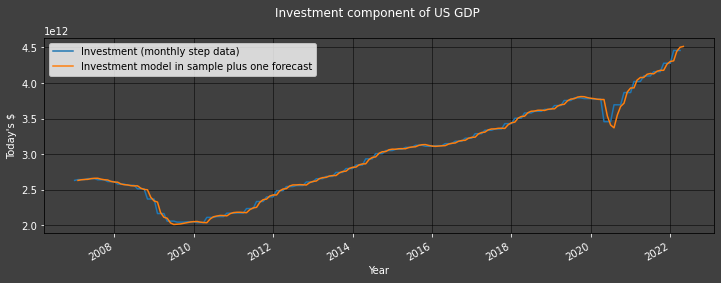

In [152]:
Plot1ax(
    title = "Investment component of US GDP", datarange = [start,-1], ylabel = "Today's $",
    dataset = df, datasubset = ["Investment (monthly step data)", "Investment model in sample plus one forecast"])

$$ \\ $$
### Back-testing our Method with Government Investment data

In [153]:
# Model:
Government_Investment_model_in_sample_plus_one_forecast = ISRPHWPOOOF(
    data_set=df,
    dataset_name="Government Investment (monthly step data)",
    start=start,
    result_name="Government Investment model in sample plus one forecast")

df = pandas.merge(
    df, Government_Investment_model_in_sample_plus_one_forecast,
    how="outer", left_index=True, right_index=True)


# Model's errors:
Government_Investment_model_in_sample_plus_one_forecast_error = pandas.DataFrame(
    df["Government Investment (monthly step data)"] - df["Government Investment model in sample plus one forecast"],
    columns=["Government Investment model in sample plus one forecast error"])

df = pandas.merge(
    df, Government_Investment_model_in_sample_plus_one_forecast_error.dropna(),
    how="outer", left_index=True, right_index=True)

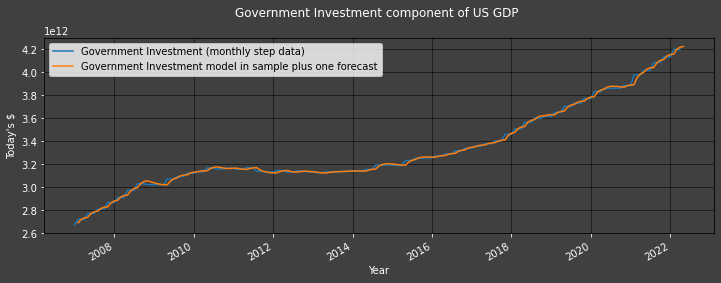

In [154]:
Plot1ax(
    title="Government Investment component of US GDP", datarange=[start,-1], ylabel="Today's $",
    dataset=df, datasubset=["Government Investment (monthly step data)",
                            "Government Investment model in sample plus one forecast"])

$$ \\ $$
### Back-testing our Method with Net Exports data

In [155]:
# Model:
Net_Exports_model_in_sample_plus_one_forecast = ISRPHWPOOOF(
    data_set = df,
    dataset_name = "Net Exports (monthly step data) positive",
    start = start,
    result_name = "Net Exports model in sample plus one forecast")

Net_Exports_min_p1 = numpy.absolute(pandas.DataFrame.min(
    df["Net Exports (monthly step data)"])) + 1

df = pandas.merge(
    df, Net_Exports_model_in_sample_plus_one_forecast - Net_Exports_min_p1,
    how = "outer", left_index = True, right_index = True)

In [156]:
# Model's errors:
Net_Exports_model_in_sample_plus_one_forecast_error = pandas.DataFrame(df["Net Exports (monthly step data)"] - df["Net Exports model in sample plus one forecast"],
                                                                       columns = ["Net Exports model in sample plus one forecast error"])

In [157]:
df = pandas.merge(df, Net_Exports_model_in_sample_plus_one_forecast_error.dropna(),
                  how = "outer", left_index = True, right_index = True)

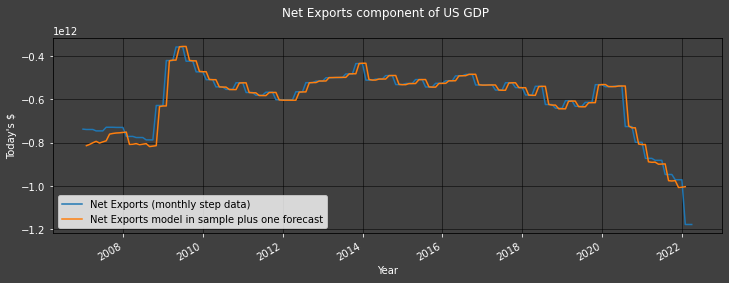

In [158]:
Plot1ax(title = "Net Exports component of US GDP", datarange = [start,-1], ylabel = "Today's $",
        dataset = df, datasubset = ["Net Exports (monthly step data)",
                                    "Net Exports model in sample plus one forecast"])

$$ \\ $$
## G.D.P. Monthly Estimates

In [159]:
df["Computed GDP"] = df["Consumption (monthly data)"] + df["Investment model in sample plus one forecast"] + df["Government Investment model in sample plus one forecast"] + df["Net Exports model in sample plus one forecast"]

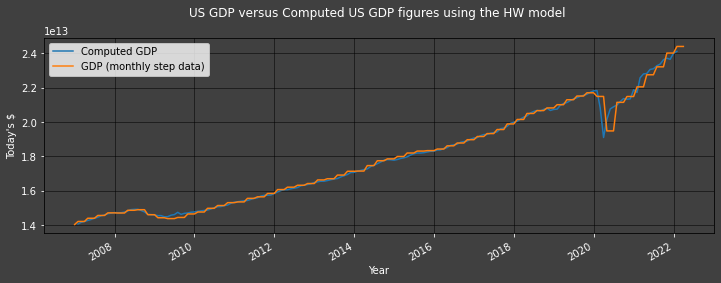

In [160]:
Plot1ax(title = "US GDP versus Computed US GDP figures using the HW model", datarange = [start,-1], ylabel = "Today's $",
        dataset = df, datasubset = ["Computed GDP", "GDP (monthly step data)"])

In [161]:
df

,Consumption (monthly data),Investment (quarterly data),Investment (monthly step data),Government Investment (quarterly data),Government Investment (monthly step data),Net Exports (quarterly data),Net Exports (monthly step data),GDP Component Sum (quarterly data),GDP Component Sum (monthly step data),GDP (every quarter),GDP (monthly step data),Investment fitted values (monthly step data),Investment forecasts (monthly step data),Investment fitted values' real errors (monthly step data),Government Investment fitted values (monthly step data),Government Investment forecasts (monthly step data),Government Investment fitted values' real errors (monthly step data),Net Exports (monthly step data) positive,Net Exports fitted values (monthly step data),Net Exports forecasts (monthly step data),Net Exports fitted values' real errors (monthly step data),Investment model in sample plus one forecast,Investment model in sample plus one forecast error,Government Investment model in sample plus one forecast,Government Investment model in sample plus one forecast error,Net Exports model in sample plus one forecast,Net Exports model in sample plus one forecast error,Computed GDP
1950-02-01,NaN,4.472500e+10,4.472500e+10,4.895600e+10,4.895600e+10,2.203000e+09,2.203000e+09,NaN,NaN,2.808280e+11,2.808280e+11,4.376023e+10,NaN,-9.647716e+08,4.869539e+10,NaN,-2.606060e+08,1.180107e+12,2.203000e+09,NaN,1.708984e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-03-01,NaN,NaN,4.472500e+10,NaN,4.895600e+10,NaN,2.203000e+09,NaN,NaN,NaN,2.808280e+11,4.583060e+10,NaN,1.105601e+09,4.905330e+10,NaN,9.730475e+07,1.180107e+12,2.203000e+09,NaN,1.708984e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04-01,NaN,NaN,4.472500e+10,NaN,4.895600e+10,NaN,2.203000e+09,NaN,NaN,NaN,2.808280e+11,4.638194e+10,NaN,1.656937e+09,4.920545e+10,NaN,2.494520e+08,1.180107e+12,2.203000e+09,NaN,1.708984e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-05-01,NaN,4.945800e+10,4.945800e+10,4.964300e+10,4.964300e+10,1.643000e+09,1.643000e+09,NaN,NaN,2.903830e+11,2.903830e+11,4.614662e+10,NaN,-3.311381e+09,4.923815e+10,NaN,-4.048485e+08,1.179547e+12,2.203000e+09,NaN,5.600000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-06-01,NaN,NaN,4.945800e+10,NaN,4.964300e+10,NaN,1.643000e+09,NaN,NaN,NaN,2.903830e+11,4.931721e+10,NaN,-1.407933e+08,4.966527e+10,NaN,2.227154e+07,1.179547e+12,1.646544e+09,NaN,3.544005e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.546315e+12,NaN,NaN,4.240523e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.575756e+12,NaN,NaN,4.255927e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
